<h4>Advection diffusion equation</h4>
<h4 >1. Mathematical form : </h4>
<h4>$\frac{\partial \phi}{\partial t}+\nabla \cdot(\boldsymbol{c} \phi)=\nabla \cdot(D \nabla \phi)\hspace{4mm}(1)$</h4>
<h4 >2. Simplified form : </h4>
<h4>With c and D constant, one dimension</h4>
<h4>$ \frac{\partial{\phi}}{\partial{t}}+ c\frac{\partial{\phi}}{\partial{x}} = D\frac{\partial^2{\phi}}{\partial x^2} \hspace{4mm}(1)$</h4>

<h4 >3. Initial conditions : </h4>
<h4>$ u(x,0) = e^{-x^2}$</h4>


In [27]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from IPython.display import HTML
c = 1
d = 0.1
D =0.05

In [28]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print("GPU Device:", device)

Num GPUs Available:  1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [29]:
deltat = 0.05
deltax = 0.2
alpha = c*deltat/deltax
t = 10

nt = int(t/deltat)
nx = int(40/deltax)

x = np.linspace(0, 40, nx)
u = np.exp(-(x-3)**2)

In [36]:
def MLP(n_input1, n_input2, n_output, n_neuron, n_layer, act_fn):
    input1 = keras.layers.Input(shape=(n_input1,))
    input2 = keras.layers.Input(shape=(n_input2,))

    
    merged = keras.layers.concatenate([input1, input2])
    hidden_layers=[]
    
    for _ in range(n_layer):
        hidden = keras.layers.Dense(
            units=n_neuron,
            activation=act_fn,
            kernel_initializer=tf.keras.initializers.GlorotNormal())
        hidden_layers.append(hidden)
        
    for hidden in hidden_layers:
            merged = hidden(merged)
        
    
    output = keras.layers.Dense(
            units=n_output,
            activation=act_fn,
            kernel_initializer=tf.keras.initializers.GlorotNormal()
            )(merged)
    
    model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)    

    return model

class EarlyStopping:

    def __init__(self, patience=10, verbose=0):
        self.stopped = 0
        self.epoch = 0 
        self.pre_loss = float('inf') 
        self.patience = patience
        self.verbose = verbose # 早期終了メッセージの出力フラグをパラメーターで初期化

    def __call__(self, current_loss):

        if self.pre_loss < current_loss: 
            self.epoch += 1 

            if self.epoch > self.patience:
                self.epoch = 0
                self.pre_loss = current_loss 
                return True

        else: 
            self.epoch = 0 
            self.pre_loss = current_loss 

        return False


class PhysicsInformedNNs():

    def __init__(self, n_input1,n_input2, n_output, n_neuron, n_layer, epochs, act_fn='tanh'):
        self.n_input1 = n_input1
        self.n_input2 = n_input2
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer
        self.epochs = epochs
        self.act_fn = act_fn
        self.loss_loc = []
        self.batch = []
        self.min_learning_rate = 1.0e-7

    def build(self, optimizer, loss_fn, early_stopping, factor):
        self._model = MLP(self.n_input1,self.n_input2, self.n_output, self.n_neuron, self.n_layer, self.act_fn)
        self._optimizer = optimizer
        self._loss_fn = loss_fn
        self._early_stopping = early_stopping
        self.factor = factor
        return self

    def train_step(self, t_data1,x_data1, u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c,loop):
        with tf.GradientTape() as tape_total:
            tape_total.watch(self._model.trainable_variables)
            u_pred_1 = self._model([t_data1, x_data1])
            u_pred_2 = self._model([t_data2, x_data2])
            loss1_1 = self._loss_fn(u_pred_1, u_data1)
            loss1_2 = self._loss_fn(u_pred_2, u_data2)
            loss1 = loss1_1 + loss1_2
            loss1 = tf.cast(loss1, dtype=tf.float32)
            
            with tf.GradientTape() as tape1:  
                tape1.watch(t_pinn)
                u_pred_pinn = self._model([t_pinn, x_pinn])
            u_t = tape1.gradient(u_pred_pinn, t_pinn)
            
            with tf.GradientTape() as tape2:
                tape2.watch(x_pinn)
                with tf.GradientTape() as tape3:
                    tape3.watch(x_pinn)
                    u_pred_pinn = self._model([t_pinn, x_pinn])
                u_x = tape3.gradient(u_pred_pinn, x_pinn)
            u_xx = tape2.gradient(u_x, x_pinn)    

            u_t = tf.cast(u_t, dtype=tf.float32)
            u_x = tf.cast(u_x, dtype=tf.float32)
            u_xx = tf.cast(u_xx, dtype=tf.float32)

            loss_physics = u_t + c * u_x -d*u_xx
            loss2 = self._loss_fn(loss_physics, tf.zeros_like(loss_physics))
            loss2 = tf.cast(loss2, dtype=tf.float32)
         
            loss = loss1 + loss2 
            
        self._optimizer.minimize(loss, self._model.trainable_variables, tape=tape_total)
        self._loss_values.append(loss)
        
        if loop % 300 ==0:
            self.loss_loc.append(loss.numpy())
            self.batch.append(loop)
            print("loss1_1: ",loss1_1.numpy(),"loss1_2:", loss1_2.numpy(),"loss2: ",loss2.numpy(),"loss: ",loss.numpy(),  "train_step:",loop)
       # if loop % 500 == 0:
          #  u_pred_test = self._model([t_data1, x_data1])
           # plt.plot(x_data1, u_pred_test, label="loop{}".format(loop))
          #  plt.legend()
           # plt.grid()
           # plt.show()
        return self

    def train(self, t_data1, x_data1,u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c):
        self._loss_values = []
        self.loop = 0
        self.stopped = 0
        for i in range(self.epochs):
            self.loop += 1
            self.train_step(t_data1, x_data1,u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c, self.loop)
            if self._early_stopping(self._loss_values[-1]):
                self._optimizer.learning_rate.assign(self._optimizer.learning_rate * self.factor)
                print("current_learning_rate:" , self._optimizer.learning_rate)
                self.stopped +=1
                if self.stopped >12:
                    print("early stopping")
                    break
                else:
                    continue

In [37]:
# boundary condition
points = 200
x_pinn = np.array([np.linspace(0,40, points)]*points)
x_pinn = tf.reshape(x_pinn,[-1,1])

t_pinn = tf.linspace(0,t, points)
t_pinn = tf.reshape(t_pinn, [-1,1])
t_pinn = tf.tile(t_pinn, [1, points])
t_pinn = tf.reshape(t_pinn, [-1,1])
t_input = tf.linspace(0,t, nt)


x_boundary_points = [i for i in range(nx)]
t_boundary_points = [0]
u_boundary_points = [i for i in range(nx)]

x_data1 = tf.gather(x, x_boundary_points )
u = np.exp(-(x_data1-3)**2)
x_data1 = tf.reshape(x_data1,[-1,1])
t_data1 = tf.zeros_like(x_data1)
u_data1 = tf.gather(u, u_boundary_points )
u_data1 = tf.reshape(u_data1 , [-1,1])

t_starting_points = [i for i in range(nt)]
u_starting_points = [0]


t_data2 = tf.gather(t_input, t_starting_points)
t_data2 = tf.reshape(t_data2, [-1,1])
x_data2= tf.zeros_like(t_data2)
u_data2= tf.gather(u, u_starting_points)
u_data2= tf.reshape(u_data2, [-1,1])

In [39]:
c = 1
PINNs = PhysicsInformedNNs(1,1,1,48,4,20000)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.10)
loss_fn = tf.keras.losses.MeanSquaredError()
early_stopping = EarlyStopping(patience=180,verbose=1)
PINNs.build(optimizer, loss_fn, early_stopping, 0.20)
PINNs.train( t_data1,x_data1, u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c)

current_learning_rate: <tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.020000001>
loss1_1:  0.048030739041103006 loss1_2: 0.9984569899081667 loss2:  0.00037554296 loss:  1.0468632 train_step: 300
loss1_1:  0.00019177762942091108 loss1_2: 5.6712284364302e-06 loss2:  0.0015640678 loss:  0.0017615167 train_step: 600
loss1_1:  8.104137032059422e-05 loss1_2: 4.116447279137342e-06 loss2:  0.0010099001 loss:  0.0010950579 train_step: 900
loss1_1:  4.272588031794087e-05 loss1_2: 1.444284962616124e-06 loss2:  0.0007036848 loss:  0.000747855 train_step: 1200
loss1_1:  2.1399936648110655e-05 loss1_2: 6.101192485038644e-07 loss2:  0.0005218822 loss:  0.00054389227 train_step: 1500
loss1_1:  1.4903427217813202e-05 loss1_2: 3.6395892911422013e-07 loss2:  0.00044209833 loss:  0.0004573657 train_step: 1800
loss1_1:  1.2826450622503652e-05 loss1_2: 2.8776485566841367e-07 loss2:  0.0004004287 loss:  0.0004135429 train_step: 2100
loss1_1:  0.00016038344802234885 loss1_2: 0.00026332843

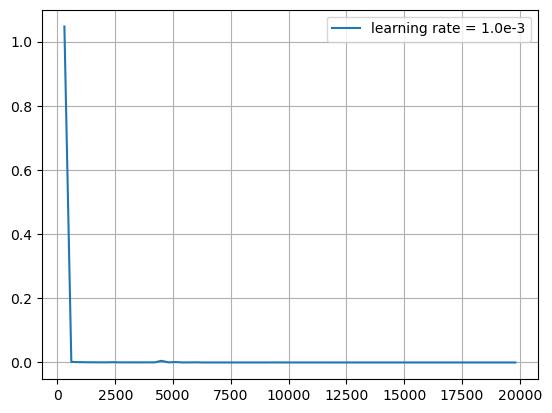

In [40]:
plt.plot(PINNs.batch,PINNs.loss_loc, label = "learning rate = 1.0e-3")
plt.grid(True)
plt.legend()
plt.show()
loss_loc1 = PINNs.loss_loc
batch1 = PINNs.batch

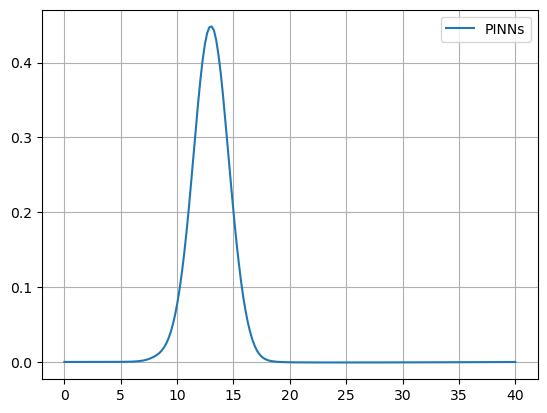

In [41]:
x_test = np.linspace(0,40,nx)
t_test = tf.linspace(0,t,nt)
u_pred=[]
for i in range(nt):
    tt = tf.fill(nx, t_test[i])
    u_pred.append(np.reshape(PINNs._model([tt,x_test]), (-1)))
    
t_test = np.array([t] * nx)
t_test = tf.reshape(t_test, [-1,1])
u_4sec_PINNs = PINNs._model([t_test, x_test], (-1))
u_4sec_true = np.exp(-(x_test -3 -t) ** 2) 
plt.plot(x_test, u_4sec_PINNs, label="PINNs")
plt.grid(True)
plt.legend()
plt.show()

In [42]:
def update_plot(num):
    
    ax.cla()
    
    ax.plot(x_test, u_pred[num], label="PINNs")
    ax.set_title('Fluid Flow Animation')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid()


fig = plt.figure()
ax = fig.add_subplot()
ani = animation.FuncAnimation(fig, update_plot, frames=nt, interval=10)
ani.save("exponential_advection_deffusion.gif", writer="imagemagick")
plt.close()
HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.
